In [11]:
from main import main
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pickle
%matplotlib inline

In [12]:
# Set the style for latex-like plots
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

In [13]:
# Read results from pickles.
seeds = ['0.1', '0.2', '0.5']
metrics_names = ['precision', 'recall', 'f1_score']
metrics = {}
timings = {}

for m in metrics_names:
    metrics[m] = {}
for s in seeds:
    with open("data/pkl/{seed}/precisions.pkl".format(seed=s), "rb") as f:
        metrics['precision'][s] = pickle.load(f)
    with open("data/pkl/{seed}/recalls.pkl".format(seed=s), "rb") as f:
        metrics['recall'][s] = pickle.load(f)
    with open("data/pkl/{seed}/f1_scores.pkl".format(seed=s), "rb") as f:
        metrics['f1_score'][s] = pickle.load(f)
    with open("data/pkl/{seed}/timings.pkl".format(seed=s), "rb") as f:
        timings[s] = pickle.load(f)

## Mean metric by iteration
Compute the mean of the measurements obtained for every metric and every seed, divided by the iteration.
Plot for all metrics and seeds the trend of the means, with error-bars.

In [14]:
def compute_mean_and_std_by_metric(metric: list):
    """
    Compute the mean and the standard deviation for each metric,
    grouped by every iteration of the algorithm.
    
    Arguments:
        metric: the name of the metric, among 'precision', 'recall' and 'f1_score' 
    Returns:
        
    """
    metric_means = []
    metric_stds = []   
    last_iter = max(metric[0].keys()) + 1
    for i in range(last_iter):
        iter_values = [val[i] for val in metric]
        metric_means.append(np.mean(iter_values))
        metric_stds.append(np.std(iter_values))
    return metric_means, metric_stds

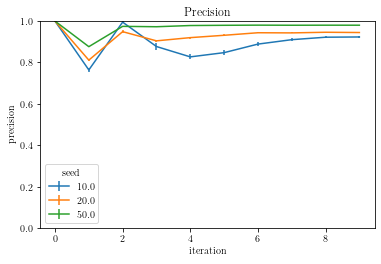

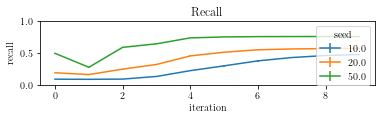

RuntimeError: latex was not able to process the following string:
b'F1_score'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/stefano/.cache/matplotlib/tex.cache/182cefddcf47ee0c3be294223be8e16d.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 182cefddcf47ee0c3be294223be8e16d.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 \fontsize{12.000000}{15.000000}{\rmfamily F1_
                                                  score}
No pages of output.
Transcript written on 182cefddcf47ee0c3be294223be8e16d.log.




<Figure size 432x288 with 1 Axes>

In [15]:
seeds = ['0.1', '0.2', '0.5']
metrics_names = ['precision', 'recall', 'f1_score']
plt.subplots_adjust(left=None, bottom=None, right=None, top=3, wspace=None, hspace=0.5)
for i, metric in enumerate(metrics_names):
    plt.subplot(3, 1, i+1, ymargin=1)
    for s in seeds:
        metric_means, metric_std = compute_mean_and_std_by_metric(metrics[metric][s])
        plt.title(metric.capitalize())
        axes = plt.gca()
        axes.set_ylim([0,1])
        plt.xlabel("iteration")
        plt.ylabel(metric)
        plt.errorbar(range(len(metric_means)), metric_means, yerr=metric_std, label=str(float(s)*100)+"%")
    plt.legend(title="seed")
    plt.show()

## Time for seed
Plot the average time (with confidence intervals) for every experiment, divided by seed.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc970841a00>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc970841730>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc9709c8a60>,
 'medians': [<matplotlib.lines.Line2D at 0x7fc970d42730>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc9709c8d90>,
 'means': []}

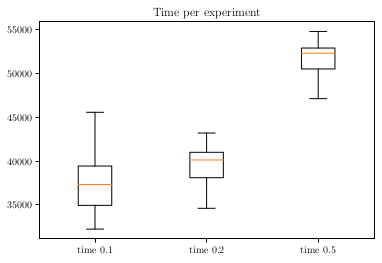

In [187]:
plt.title("Time per experiment")
plt.boxplot([timings['0.1'], timings['0.2'], timings['0.5']], labels=['time 0.1', 'time 0.2', 'time 0.5'])
# No idea why we cannot do it:
#plt.boxplot([timings[s] for s in seeds], labels=[s for s in seeds])

## Confidence interval of last iteration's metrics
Plot the 95% confidence interval by bootstrapping the results obtained in the last iteration, for every metric and seed.

In [162]:
def bootstrap_metric(metric_list, n_iter):
    """Compute bootstrap means list to be used for computing confidence intervals
        using bootstrap resample"""
    means = []
    last_iter = max(metric_list[0].keys())
    metric_last = [val[last_iter] for val in metric_list]
    for i in range(n_iter):
        # Bootstrap
        metric_sample = np.random.choice(metric_last, size=len(metric_last), replace=True)
        means.append(np.mean(metric_sample))

    return means

In [163]:
def confidence_interval(means, conf_percent):
    # Computing low quantile (2.5 in our case)
    low_p = ((1.0 - conf_percent) / 2.0) * 100
    lower = np.percentile(means, low_p)

    # Computing high quantile
    high_p = (conf_percent + ((1.0 - conf_percent) / 2.0)) * 100
    upper = np.percentile(means, high_p)

    return [lower, upper]

In [171]:
def plot_confidence(means_metric, interval, index):
    # Computing the mean error
    mean = np.mean(means_metric)
    
    plt.subplots(9, 1, index+1)
    # Plot scores
    plt.hist(means_metric, bins=25)

    # Plot of two interval lines
    plt.axvline(interval[0], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(interval[1], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)

    plt.title("95.0 % confidence interval")
    plt.xlabel("A certain metric mean")
    plt.ylabel("Count")

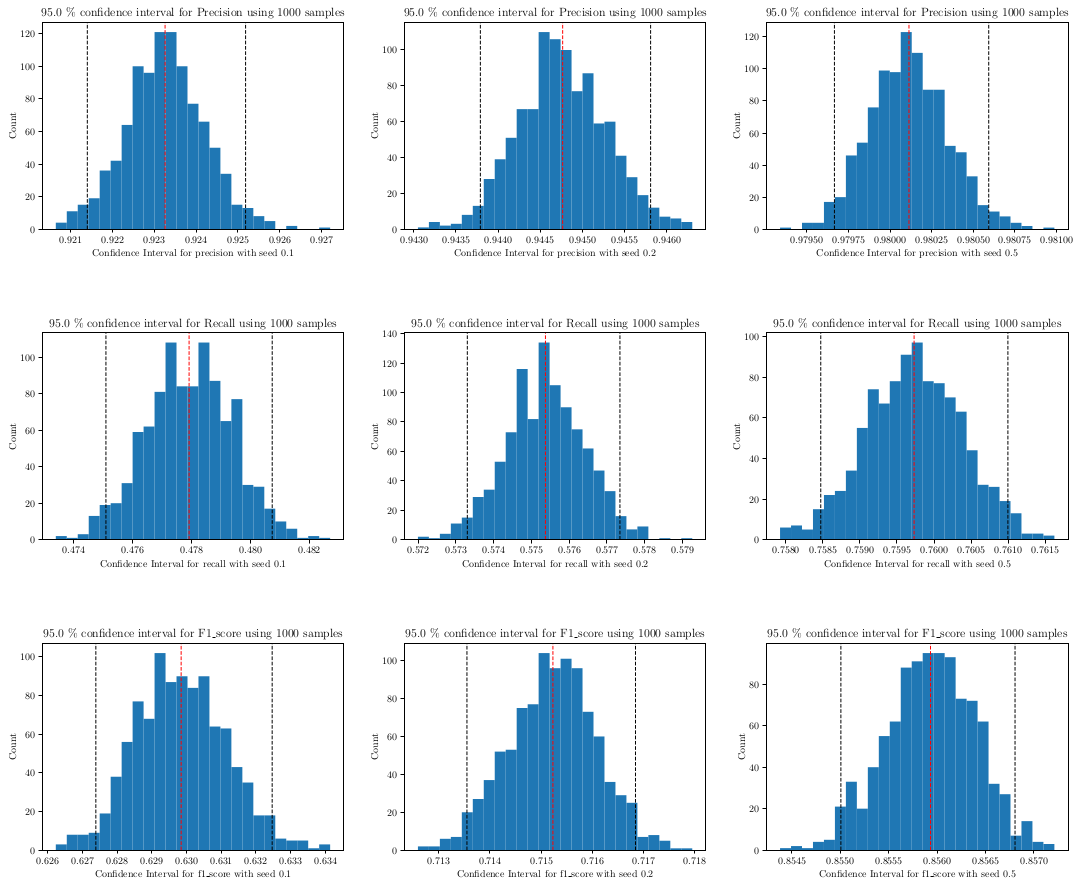

In [186]:
metrics_names = ['precision', 'recall', 'f1_score']
seeds = ['0.1', '0.2', '0.5']
index = 1
plt.subplots_adjust(left=None, bottom=None, right=2.5, top=3, wspace=0.2, hspace=0.5)

for m in metrics_names:
    for s in seeds:
        means_metric = bootstrap_metric(metrics[m][s], 1000)
        interval = confidence_interval(means_metric, 0.95)
#         plot_confidence(means_precision, interval, index)
        mean = np.mean(means_metric)
    
        plt.subplot(3, 3, index)
        # Plot scores
        plt.hist(means_metric, bins=25)

        # Plot of two interval lines
        plt.axvline(interval[0], color='k', linestyle='dashed', linewidth=1)
        plt.axvline(interval[1], color='k', linestyle='dashed', linewidth=1)
        plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)

        plt.title("95.0 % confidence interval for {metric} using 1000 samples".format(metric=m.capitalize()))
        plt.xlabel("Confidence Interval for {metric} with seed {seed}".format(metric=m, seed=s))
        plt.ylabel("Count")
        index += 1 

## Plot the errors for last's iterations metrics
Plot the means (and relative errors) for the metrics obtained during the last iteration, for every metric and seed.